# Imports

In [1]:
from time import time, ctime
from math import comb
from itertools import combinations

In [2]:
import logging
from pathlib import Path
import gc
import pickle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [4]:
import torch

In [5]:
import clip

In [6]:
from imagelib import Im

In [7]:
import test

In [8]:
from tqdm.notebook import tqdm

---

In [9]:
%load_ext rich

In [10]:
%load_ext autoreload
%autoreload 1

In [11]:
%aimport imagelib

In [12]:
%aimport test

## Config

In [13]:
np.set_printoptions(linewidth=1000)

In [14]:
plt.set_loglevel('error')

In [15]:
logging.basicConfig(level=logging.DEBUG)

In [16]:
logging.getLogger("imagelib").setLevel(logging.INFO)

In [17]:
logging.getLogger("test").setLevel(logging.DEBUG)

# Main

In [18]:
file_name = "temp.png"
category = "random"
base_dir = "data"

target = "combinations_cuda"

label_prefix = "sketch of"

gridcell_size = 8
grid_width = 28
grid_height = 28
threshold_ratio = 0.

convert = '1'
invert = False
skeleton = False

p = 0.045
seed = 5

render_w_grid = False
render_type = "circles"

model_name = 'clip'
device = "cuda"

overwrite = False
overwrite_plot = False
overwrite_animation = False

frames = 1000
interval = 50

In [19]:
models_ = clip.available_models()[::-1]
models_[::-1]

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

---

In [20]:
id = 10

In [21]:
prefix = Path(file_name.split(".")[0])

---

In [22]:
file = Im(file_name, category, base_dir=base_dir, create='random', convert=convert, invert=invert, skeleton=skeleton, p=p, seed=seed)
file.register(grid_width, grid_height, gridcell_size, threshold_ratio=threshold_ratio, object_persistency=1, seed=seed, render_w_grid=render_w_grid, render_type=render_type)

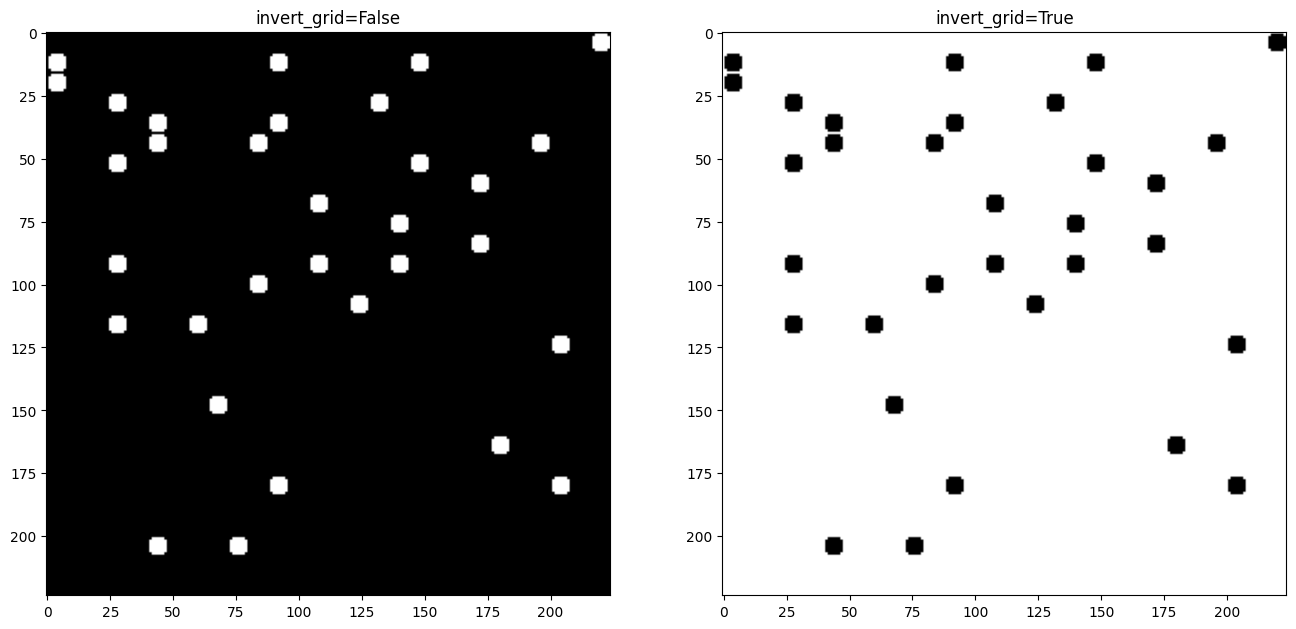

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for ax, invert_grid in zip(axs, (False, True)):
    ax.imshow(file.get_grid_image(invert=invert_grid))
    ax.set_title(f"{invert_grid=}")
plt.show()

## Combinations

In [24]:
C = {
    'letters': ['letter A', 'letter B', 'letter C', 'letter D', 'letter E', 'letter F', 'letter G', 'letter H', 'letter I', 'letter J', 'letter K', 'letter L', 'letter M', 'letter N', 'letter O', 'letter P', 'letter Q', 'letter R', 'letter S', 'letter T', 'letter U', 'letter V', 'letter W', 'letter X', 'letter Y', 'letter Z'],
    'numbers': ['number 0', 'number 1', 'number 2', 'number 3', 'number 4', 'number 5', 'number 6', 'number 7', 'number 8', 'number 9'],
    'abstract': ['randomness', 'something unknown', 'something abstract'],
    'objects': ['star', 'starfish', 'heart', 'house', 'tree', 'apple', 'moon', 'butterfly', 'cloud', 'umbrella', 'bicycle', 'balloon', 'clock', 'arrow', 'smiley face', 'book', 'rocket', 'pencil', 'cat', 'dog', 'fish', 'car', 'table', 'flower', 'number one', 'letter a', 'guitar', 'hat', 'chair', 'sun', 'key', 'cake', 'snowflake', 'ball', 'mushroom', 'glasses', 'laptop', 'candle', 'crown', 'mountain', 'island', 'cactus', 'bird', 'plane', 'lamp', 'leaf', 'shell', 'dolphin', 'sailboat', 'swan']
}

In [25]:
comb_categories = [
    C['numbers'],
    C['letters'],
    C['numbers'] + C['letters'],
    # C['abstract'],
    # C['numbers'] + C['abstract'],
    # C['abstract'] + C['letters'],
    C['numbers'] + C['letters'] + C['abstract'],
    C['objects'],
    # C['objects'] + C['numbers'],
    # C['objects'] + C['letters'],
    C['objects'] + C['numbers'] + C['letters'],
    # C['objects'] + C['abstract'],
    # C['objects'] + C['numbers'] + C['letters'] + C['abstract']
]

---

In [26]:
def combinations_(items, r):
    return (items[i : i + r] for i in range(0, len(items) - r + 1, 1))  # r
    # return combinations(items, r)

In [27]:
def comb_(n, r):
    return n - r + 1  # n // r
    # return comb(n, r)

## Permutations of combinations on different models

In [29]:
results = dict()
times = dict()
preprocess_times = dict()
tokenize_times = dict()

for model_ in models_:
    if device == "cuda":
        # Empty cache and collect garbage
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.memory_summary("cuda", abbreviated=True)

    print(model_)
    model, preprocess = clip.load(model_, device=device)

    results[model_] = dict()
    times[model_] = dict()
    preprocess_times[model_] = list()
    tokenize_times[model_] = dict()

    # model.eval()
    for invert_grid in (False, True):
        results[model_][invert_grid] = []

        results_file = f"results_{grid_width}_{grid_height}_{gridcell_size}_{invert_grid}_{render_w_grid}_{render_type}_clip={model_.replace('/', '-')}_{label_prefix.replace(' ', '-')}+NA{id}+{seed}.pickle"

        timespath = f"results/{target + '/' if target else ''}{category}" / prefix / f"times_{grid_width}_{grid_height}_{gridcell_size}_{invert_grid}_{render_w_grid}_{render_type}_clip={model_.replace('/', '-')}_{label_prefix.replace(' ', '-')}+NA{id}+{seed}.pickle"
        preprocess_timespath = f"results/{target + '/' if target else ''}{category}" / prefix / f"preprocess_times_{grid_width}_{grid_height}_{gridcell_size}_{invert_grid}_{render_w_grid}_{render_type}_clip={model_.replace('/', '-')}_{label_prefix.replace(' ', '-')}+NA{id}+{seed}.pickle"
        tokenize_timespath = f"results/{target + '/' if target else ''}{category}" / prefix / f"tokenize_times_{grid_width}_{grid_height}_{gridcell_size}_{invert_grid}_{render_w_grid}_{render_type}_clip={model_.replace('/', '-')}_{label_prefix.replace(' ', '-')}+NA{id}+{seed}.pickle"

        if not (resultpath :=  f"results/{target + '/' if target else ''}{category}" / prefix / results_file).is_file() or overwrite:
            start = time()
            image = preprocess(file.get_grid_image(invert=invert_grid)).unsqueeze(0).to(device)
            preprocess_times[model_].append(time() - start)

            for categories in (pbar := tqdm(comb_categories)):
                pbar.set_description(f"{model_:19}{' | inverted' if invert_grid else ''} | Alphabets | #(categories) = {len(categories):2}")
                if len(categories) not in tokenize_times[model_]:
                    tokenize_times[model_][len(categories)] = []
                start = time()
                text = clip.tokenize([f"{label_prefix} {label}" for label in categories]).to(device)
                tokenize_times[model_][len(categories)].append(time() - start)

                if len(categories) not in times[model_]:
                    times[model_][len(categories)] = []
                start = time()
                with torch.no_grad():
                    logits_per_image, logits_per_text = model(image, text)
                    probs = logits_per_image.softmax(dim=-1)
                    times[model_][len(categories)].append(time() - start)
                    results[model_][invert_grid].append(dict(zip(categories, probs.squeeze())))

            for i in (pbar := tqdm(range(5, len(C['objects'])))):
                pbar.set_description(f"{model_:19}{' | inverted' if invert_grid else ''} | Objects   | #(categories) = {i:2}")
                for categories in tqdm(combinations_(C['objects'], i), total=comb_(len(C['objects']), i), desc='>', leave=False):
                    if len(categories) not in tokenize_times[model_]:
                        tokenize_times[model_][len(categories)] = []
                    start = time()
                    text = clip.tokenize([f"{label_prefix} {label}" for label in categories]).to(device)
                    tokenize_times[model_][len(categories)].append(time() - start)

                    if len(categories) not in times[model_]:
                        times[model_][len(categories)] = []
                    start = time()
                    with torch.no_grad():
                        logits_per_image, logits_per_text = model(image, text)
                        probs = logits_per_image.softmax(dim=-1)
                        times[model_][len(categories)].append(time() - start)
                        results[model_][invert_grid].append(dict(zip(categories, probs.squeeze())))

            resultpath.parent.mkdir(parents=True, exist_ok=True)
            with open(resultpath, "wb") as picklefile:
                logging.info(f">> {model_:19} | Saving {'inverted ' if invert_grid else ''}results @ file://{resultpath.resolve()}.")
                pickle.dump(results[model_][invert_grid], picklefile)

            if invert_grid:
                with open(timespath, "wb") as picklefile:
                    logging.info(f">> {model_:19} | Saving inference times @ file://{timespath.resolve()}.")
                    pickle.dump(times[model_], picklefile)

                with open(preprocess_timespath, "wb") as picklefile:
                    logging.info(f">> {model_:19} | Saving preprocessing times @ file://{preprocess_timespath.resolve()}.")
                    pickle.dump(preprocess_times[model_], picklefile)

                with open(tokenize_timespath, "wb") as picklefile:
                    logging.info(f">> {model_:19} | Saving tokenize times @ file://{tokenize_timespath.resolve()}.")
                    pickle.dump(tokenize_times[model_], picklefile)

        else:
            with open(resultpath, "rb") as picklefile:
                results[model_][invert_grid] = pickle.Unpickler(picklefile).load()
                logging.info(f">> {model_:19} | Loaded {'inverted ' if invert_grid else ''}results @ file://{resultpath.resolve()}.")

            if invert_grid:
                with open(timespath, "rb") as picklefile:
                    times[model_] = pickle.Unpickler(picklefile).load()
                    logging.info(f">> {model_:19} | Loaded inference times @ file://{timespath.resolve()}.")

                with open(preprocess_timespath, "rb") as picklefile:
                    preprocess_times[model_] = pickle.Unpickler(picklefile).load()
                    logging.info(f">> {model_:19} | Loaded preprocessing times @ file://{preprocess_timespath.resolve()}.")

                with open(tokenize_timespath, "rb") as picklefile:
                    tokenize_times[model_] = pickle.Unpickler(picklefile).load()
                    logging.info(f">> {model_:19} | Loaded tokenize times @ file://{tokenize_timespath.resolve()}.")

ViT-L/14@336px


INFO:root:>> ViT-L/14@336px      | Loaded results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_False_False_circles_clip=ViT-L-14@336px_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14@336px      | Loaded inverted results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_True_False_circles_clip=ViT-L-14@336px_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14@336px      | Loaded inference times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/times_28_28_8_True_False_circles_clip=ViT-L-14@336px_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14@336px      | Loaded preprocessing times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/preprocess_times_28_28_8_True_False_circles_clip=ViT-L-14@336px_sketch-of+NA10+5.pic

ViT-L/14


INFO:root:>> ViT-L/14            | Loaded results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_False_False_circles_clip=ViT-L-14_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14            | Loaded inverted results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_True_False_circles_clip=ViT-L-14_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14            | Loaded inference times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/times_28_28_8_True_False_circles_clip=ViT-L-14_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/14            | Loaded preprocessing times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/preprocess_times_28_28_8_True_False_circles_clip=ViT-L-14_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-L/

ViT-B/16


INFO:root:>> ViT-B/16            | Loaded results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_False_False_circles_clip=ViT-B-16_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/16            | Loaded inverted results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_True_False_circles_clip=ViT-B-16_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/16            | Loaded inference times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/times_28_28_8_True_False_circles_clip=ViT-B-16_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/16            | Loaded preprocessing times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/preprocess_times_28_28_8_True_False_circles_clip=ViT-B-16_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/

ViT-B/32


INFO:root:>> ViT-B/32            | Loaded results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_False_False_circles_clip=ViT-B-32_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/32            | Loaded inverted results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/results_28_28_8_True_False_circles_clip=ViT-B-32_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/32            | Loaded inference times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/times_28_28_8_True_False_circles_clip=ViT-B-32_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/32            | Loaded preprocessing times @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda/random/temp/preprocess_times_28_28_8_True_False_circles_clip=ViT-B-32_sketch-of+NA10+5.pickle.
INFO:root:>> ViT-B/

RN50x64


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:86                                                                                   │
│                                                                                                  │
│    83 │   │                                                                                      │
│    84 │   │   else:                                                                              │
│    85 │   │   │   with open(resultpath, "rb") as picklefile:                                     │
│ ❱  86 │   │   │   │   results[model_][invert_grid] = pickle.Unpickler(picklefile).load()         │
│    87 │   │   │   │   logging.info(f">> {model_:19} | Loaded {'inverted ' if invert_grid else    │
│    88 │   │   │                                                                                  │
│    89 │   │   │   if invert_grid:                                                                │
│                                                                                                  │
│ /is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl_venv/lib/python3.8/site-packages/torch/stora │
│ ge.py:241 in _load_from_bytes                                                                    │
│                                                                                                  │
│    238 │   │   return self.device.type == 'cuda'                                                 │
│    239                                                                                           │
│    240 def _load_from_bytes(b):                                                                  │
│ ❱  241 │   return torch.load(io.BytesIO(b))                                                      │
│    242                                                                                           │
│    243                                                                                           │
│    244 _StorageBase.type = _type  # type: ignore[assignment]                                     │
│                                                                                                  │
│ /is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl_venv/lib/python3.8/site-packages/torch/seria │
│ lization.py:815 in load                                                                          │
│                                                                                                  │
│    812 │   │   │   │   return _legacy_load(opened_file, map_location, _weights_only_unpickler,   │
│    813 │   │   │   except RuntimeError as e:                                                     │
│    814 │   │   │   │   raise pickle.UnpicklingError(UNSAFE_MESSAGE + str(e)) from None           │
│ ❱  815 │   │   return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args  │
│    816                                                                                           │
│    817                                                                                           │
│    818 # Register pickling support for layout instances such as                                  │
│                                                                                                  │
│ /is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl_venv/lib/python3.8/site-packages/torch/seria │
│ lization.py:1051 in _legacy_load                                                                 │
│                                                                                                  │
│   1048 │   for key in deserialized_storage_keys:                                                 │
│   1049 │   │   assert key in deserialized_objects                                                │
│   1050 │   │   typed_storage = deserialized_objects[key]                                         │
│ ❱ 1051 │   │   typed_storage._untyped_storage._set_from_fil

### Plots

In [ ]:
for model_ in models_:
    print(f'{model_:<19} {1000 * np.mean(preprocess_times[model_]):.3f} ms')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False, sharex=True)

# fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=False, sharex=True)
# axs = [axs]

for model_ in models_:
    times_m = times[model_]
    tokenize_times_m = tokenize_times[model_]

    times_ = dict()
    for ncat in dict(sorted(times_m.items())):
        times_[ncat] = np.mean(times_m[ncat])

    tokenize_times_ = dict()
    for ncat in dict(sorted(tokenize_times_m.items())):
        tokenize_times_[ncat] = np.mean(tokenize_times_m[ncat])

    axs[0].scatter(*np.array([[t, v] for t, vs in times_m.items() for v in vs]).T, s=0.1)
    axs[0].plot(times_.keys(), times_.values(), label=model_)

    axs[1].scatter(*np.array([[t, 1000 * v] for t, vs in tokenize_times_m.items() for v in vs]).T, s=1)
    axs[1].plot(tokenize_times_.keys(), 1000 * np.array(list(tokenize_times_.values())), label=model_)

axs[0].set_ylim([0, 0.4])
axs[0].xaxis.set_major_locator(MultipleLocator(5))
axs[0].xaxis.set_major_formatter('{x:.0f}')
axs[0].xaxis.set_minor_locator(MultipleLocator(1))
axs[0].set_ylabel('Time (s)')
axs[0].set_xlabel('Number of Labels')
axs[0].set_title(f'Inference times for different CLIP models on {"CPU" if device == "CPU" else "GPU"}')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(reversed(handles), reversed(labels), loc='upper left')

axs[1].set_ylim([0, 20])
axs[1].yaxis.set_tick_params(labelleft=True)
axs[1].xaxis.set_major_locator(MultipleLocator(5))
axs[1].xaxis.set_major_formatter('{x:.0f}')
axs[1].xaxis.set_minor_locator(MultipleLocator(1))
axs[1].set_ylabel('Time (ms)')
axs[1].set_xlabel('Number of Labels')
axs[1].set_title(f'Tokenize times for different CLIP models')
# axs[1].legend()

plt.tight_layout()

### Combination selection per model

In [ ]:
ENTROPY_THRESHOLD = 0.90  # 0.999

In [ ]:
# calc_entropy = lambda l: -np.array(list(l)) @ np.log(list(l)) / np.log(len(l))
calc_entropy = lambda l: -(l := np.array(torch.tensor(list(l)).cpu())) @ np.log(l) / np.log(len(l))

---

In [ ]:
entropy_ratios = {model_: {invert_grid: [calc_entropy(result.values()) for result in results[model_][invert_grid]] for invert_grid in (False, True)} for model_ in models_}

In [ ]:
selected_categories = {model_: {invert_grid: {tuple(categories.keys()) for entropy_ratio, categories in zip(entropy_ratios[model_][invert_grid], results[model_][invert_grid]) if entropy_ratio > ENTROPY_THRESHOLD} for invert_grid in (False, True)} for model_ in models_}

In [ ]:
selected_categories

---

In [28]:
models__ = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14'][::-1]

In [ ]:
{model_: {i: k for i, d in times[model_].items() if (k := np.mean(d)) < 1 and i > 9} for model_ in models_ if model_ not in models__}

In [ ]:
# TOTAL - 1,125.899909210013E+12
for model_ in models_:
    print(f'{model_:19} {str(False):10} {len(selected_categories[model_][False])}')
    print(f'{"":19} {str(True):10} {len(selected_categories[model_][True])}')

## Rollouts

In [28]:
models__ = ['RN50x16', 'ViT-L/14']

In [29]:
ctime()

'Tue Sep 26 02:46:19 2023'

### Random

> Run rollout for the selected categories with corresponding inversion

In [29]:
ctime()

'Tue Sep 26 02:08:36 2023'

### 0

> Run rollout for the main combinations of categories on an actual image (mnist/0)

In [ ]:
for model_ in tqdm(models__):
    model, preprocess = clip.load(model_, device=device)
    for invert_grid in (False, True):
        for categories in tqdm(comb_categories, desc=f'{model_} {invert}'):
            logging.info(f"{invert_grid=} | {categories}")
            test.rollout('1001.png',
                         category='0',
                         base_dir='data/mnist',
                         categories=categories,
                         label_prefix=label_prefix,
                         gridcell_size=gridcell_size,
                         grid_width=grid_width,
                         grid_height=grid_height,
                         threshold_ratio=threshold_ratio,
                         convert=convert,
                         invert=invert,
                         skeleton=True,
                         invert_grid=invert_grid,
                         render_w_grid=render_w_grid,
                         render_type=render_type,
                         seed=seed,
                         overwrite=True,
                         # overwrite_plot=overwrite_plot,
                         # overwrite_animation=overwrite_animation,
                         model_name=model_name,
                         model_version=model_,
                         model_=(model, preprocess),
                         device=device,
                         frames=frames,
                         interval=interval,
                         target=f"{target}_{model_.replace('/', '-')}")

  0%|          | 0/2 [00:00<?, ?it/s]

RN50x16 False:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:root:invert_grid=False | ['number 0', 'number 1', 'number 2', 'number 3', 'number 4', 'number 5', 'number 6', 'number 7', 'number 8', 'number 9']
INFO:test:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
DEBUG:test:> base_dir='data/mnist'
DEBUG:test:> model_name='clip' @ model_version='RN50x16'
DEBUG:test:> category='0' / file_name='1001.png' ('1') (skeleton) ("'sketch of' ...number 0?")
DEBUG:test:> categories=['number 0', 'number 1', 'number 2', 'number 3', 'number 4', 'number 5', 'number 6', 'number 7', 'number 8', 'number 9']
DEBUG:test:> grid ~ [28 x 28] * 8 > threshold_ratio=0.0
DEBUG:test:> invert_grid=False
DEBUG:test:> render_w_grid=False
DEBUG:test:> render_type='circles'
DEBUG:test:> seed=5
DEBUG:test:> overwrite=True ; overwr

> Pre-processing images...:   0%|          | 0/1000 [00:00<?, ?it/s]

DEBUG:test:>> Saved pre-processed images @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/data/mnist/0/1001/pre-processed_28_28_8_False_False_circles.
DEBUG:test:>> Saved processed images @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/data/mnist/0/1001/processed_28_28_8_False_False_circles_clip=RN50x16.
DEBUG:test:>> Saved meta data @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/data/mnist/0/1001/pre-processed_28_28_8_False_False_circles/meta.pickle.
DEBUG:test:> Pre-processing labels...
DEBUG:test:> Running inference on clip=RN50x16 model ...


> Running Inference...:   0%|          | 0/1000 [00:00<?, ?it/s]

DEBUG:test:>> Saving results @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/data/mnist/0/1001/results/results_28_28_8_False_False_circles_clip=RN50x16_sketch-of+number 0_number 1_nu++89+5_1000.pickle.
INFO:test:> For the original file, entropy/max_entropy=0.95, and entropy/grid_entropy=1.01
DEBUG:test:> Plotting results...
DEBUG:test:>> Saved plot @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda_RN50x16/0/plot_1001_28_28_8_False_False_circles_clip=RN50x16_sketch-of+number 0_number 1_nu++89+5_1000.png.
DEBUG:test:> Creating animation with interval 50 ms.
DEBUG:test:>> Saved animation @ file:///is/sg2/pgoyal/Desktop/Projects/mbrl-semantics/mbrl/environments/results/combinations_cuda_RN50x16/0/animation_1001_28_28_8_False_False_circles_clip=RN50x16_sketch-of+number 0_number 1_nu++89+5_1000_50.mp4.
INFO:test:>>~Done~>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

> Pre-processing images...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ctime()